In [1]:
import pandas as pd
import numpy as np
from sklearn.externals import joblib
from keras.models import load_model
import pickle
import time

import matplotlib.pylab as plt
%matplotlib inline
plt.style.use('seaborn')

C:\Users\eduardo.hernanz\AppData\Local\Continuum\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
#Como tenemos procesado todo en el mismo fichero, lo cargamos

path = '../Entrenamientos/Procesado_Tramos.xlsx'
df = pd.read_excel(path)

In [3]:
#Eliminar las filas que no tienen datos y seleccionamos la prueba que queremos simular

#df = df[df["viento_aparente"]!=-np.inf]
df = df[df["porc"]!=np.inf]
#df["puntos_en_tramo"]= df["tramo_final"]-df["tramo_inicial"]
#df = df[df["puntos_en_tramo"]>250]
#df = df[df["porc"]>2]
df = df[df["prueba"]=="20180429_LEMG_195_90_R_C.gpx"]

In [4]:
df.describe()

,tramo,tramo_inicial,tramo_final,pwr,time_seg,dist,spd,viento_aparente,porc,dist_acum
count,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000
mean,60.500000,3496.016393,3547.770492,207.940679,94.262295,726.590164,35.150620,-1.333628,0.058167,49403.237132
std,35.362409,1946.877241,1937.072375,52.063138,172.804471,1130.014691,12.474903,13.483191,2.092644,27074.087892
min,0.000000,0.000000,16.000000,22.992004,1.000000,9.697469,12.922105,-14.992324,-6.597866,173.532309
25%,30.250000,2196.750000,2230.750000,180.272469,7.000000,61.750000,26.661969,-14.375875,-0.870941,30967.492612
50%,60.500000,3286.500000,3353.500000,223.516007,50.500000,466.777042,33.203336,-6.759451,0.003106,47158.500000
75%,90.750000,5248.500000,5283.500000,241.060519,92.750000,847.570583,41.207362,14.235446,0.859900,72401.000000
max,121.000000,6300.000000,6314.000000,299.800000,1158.000000,8788.000000,75.302316,14.918299,7.046886,88630.000000


In [5]:
#Se revisa que no existan datos anómalos
df.head()

,tramo,tramo_inicial,tramo_final,pwr,time_seg,dist,spd,viento_aparente,porc,dist_acum,prueba
0,0,0,16,196.808012,17,187.41664,39.688230,14.918299,-0.399565,173.532309,20180429_LEMG_195_90_R_C.gpx
1,1,16,75,230.996299,98,886.58336,32.568368,14.577416,0.523132,1055.000000,20180429_LEMG_195_90_R_C.gpx
2,2,75,122,194.043315,60,616.40000,36.984000,14.550887,-0.240187,1677.304307,20180429_LEMG_195_90_R_C.gpx
3,3,122,227,221.693546,193,1692.60000,31.571813,14.552940,0.895103,3364.000000,20180429_LEMG_195_90_R_C.gpx
4,4,227,273,169.324586,47,538.40000,41.239149,14.433466,-1.235191,3911.000000,20180429_LEMG_195_90_R_C.gpx


(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  1.,  1.,  1.,  0.,  2.,  0.,  0.,  1.,  1.,
         0.,  3.,  0.,  0.,  1.,  0.,  2.,  1.,  3.,  1.,  0.,  1.,  4.,
         3.,  2.,  1.,  1.,  3.,  1.,  3.,  3., 11., 18.,  8.,  1.,  3.,
         3.,  3.,  4.,  1.,  2.,  1.,  2.,  1.,  0.,  1.,  1.,  2.,  1.,
         1.,  1.,  1.,  1.,  2.,  3.,  2.,  0.,  2.,  0.,  0.,  0.,  0.,
         0.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  1.]),
 array([-6.59786614, -6.46141862, -6.32497111, -6.18852359, -6.05207607,
        -5.91562855, -5.77918103, -5.64273351, -5.50628599, -5.36983847,
        -5.23339095, -5.09694343, -4.96049591, -4.82404839, -4.68760087,
        -4.55115335, -4.41470584, -4.27825832, -4.1418108 , -4.00536328,
        -3.86891576, -3.73246824, -3.59602072, -3.4595732 , -3.32312568,
        -3.18667816, -3.05023064, -2.91378312, -2.7773356 , -2.640888

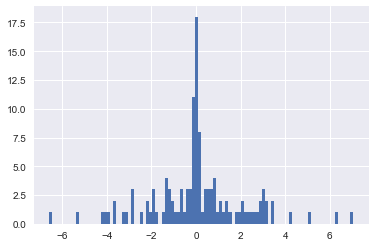

In [6]:
plt.hist(df['porc'],bins=100)

In [7]:
#Prueba iterando en cada tramo con intervalos aleatorios con el modelo desarrollado CON TENSORFLOW (PRIMERA PASADA)

#Almacenamos la hora de inicio para evaluar el tiempo que tarda en ejecutar
start_time = time.time()



#Cargamos los dos modelos con los que vamos a trabajar
pre_model = joblib.load('../Machine Learning/regr_porc_pwr.model') 

model_TF = load_model('../RNN/TF_Tramos_2.model')
model_Scalar = pickle.load(open("../RNN/Scaler.model", "rb"))



#Inicializamos las variables de control del flujo de ejecución
potencia_objetivo = 220
multiplicador_potencia = potencia_objetivo/pre_model.intercept_

resultados = []
fail = 0
exito = 0
num_pruebas = 50
fi = 0

pot_min = 50
pot_max = 300
ff_1 = 0.5
ff_2 = 0.5

#Repetimos la simulación de pruebas hasta que tenemos un número de existos concreto
while exito < num_pruebas:
    #print(exito)
    if (fi % 1000) == 0:
        print('Empezamos la prueba %d' %fi)
        print("--- %s seconds ---" % (time.time() - start_time))
    
    #Reiniciamos la varaibles para acumular cada prueba
    potencia_acum = 0
    tiempo_acum = 0
    i= 0
    lista_tramo_potencia = []
    
    #Simulamos cada tramo de la prueba uno a uno
    while i < len(df):
        
        #Recuperamis el porcentaje de la pendiente, el viento y la distancia
        porc = df[i:i+1]["porc"].iloc[0]
        viento = df[i:i+1]["viento_aparente"].iloc[0]
        distancia = df[i:i+1]["dist"].iloc[0]
        
        #if porc < -2:
        #    potencia = pre_model.predict(porc)[0][0]*multiplicador_potencia+np.random.randint(-abs(porc), abs(porc))
        #elif porc > 2:
        #    #potencia = pre_model.predict(porc)[0][0]+50+np.random.randint(-abs(porc**2), abs(porc**2))
        #    potencia =potencia_objetivo+np.random.randint(0, abs(porc)+50)
        #else:
        #    potencia = potencia_objetivo+np.random.randint(-abs(porc)-10, abs(porc)+30)
        
        #potencia con una sigmoide
        #DAVID METE AQUI UNA EXPLICACION           
        potencia = pot_min+(pot_max-pot_min)/(1+ff_1*np.e**(ff_2*porc*-1))+np.random.randint(-1*(abs(viento)+1), abs(viento)+1)
        
        #Utilizamos el modelo de normalización entrenado para ajustar los datos de entrada
        input_model = model_Scalar.transform([[potencia, porc, viento]])
        
        #Utilizamos el modelo de Tensor Flow para predecir la velocidad media de ese tramo
        velocidad = model_TF.predict(input_model)[0]
        
        #Con la velocidad del paso anterior y la distancia del tramo, calculamos el tiempo necesario para recorrerlo
        nuevo_tiempo = distancia/(velocidad/3.6)
        #Almacenamos la información del paso actual
        lista_tramo_potencia.append([i, potencia,velocidad[0],distancia,nuevo_tiempo[0],porc,viento])
        
        #Acumulamos la potencia y el tiempo para evaluar el resultado final y determinar si es éxito o no, y con que tiempo total
        potencia_acum = potencia_acum + (potencia * nuevo_tiempo)
        tiempo_acum = tiempo_acum + nuevo_tiempo
        
        i += 1
    
    potencia_media = potencia_acum/tiempo_acum
    print("Intento %d con potencia media %d" %(fi, potencia_media))
    
    #Si la pontencia queda fuera de intervalos viables, no se considera como exito
    #Nos quedamos con +/-20w sobre la potencia objetivo para luego seleccionar las mejores distribuciones de potencia
    if (potencia_media > potencia_objetivo-20) and (potencia_media < potencia_objetivo+20):
        #print(potencia_media, tiempo_acum)
        resultados.append([fi,potencia_media[0], tiempo_acum[0], lista_tramo_potencia])
        exito +=1
    else:
        #Contamos las simulaciones consideradas sin exito
        fail +=1
    
    fi +=1

print("---Total time: %s seconds ---" % (time.time() - start_time))

print('Casos descartados: %d' %fail)
print('Casos de favorables: %d' %(len(resultados)))

C:\Users\eduardo.hernanz\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\base.py:311: UserWarning: Trying to unpickle estimator LinearRegression from version 0.18.1 when using version 0.19.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\eduardo.hernanz\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\base.py:311: UserWarning: Trying to unpickle estimator RobustScaler from version 0.18.1 when using version 0.19.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Empezamos la prueba 0
--- 0.9752101898193359 seconds ---
Intento 0 con potencia media 221
Intento 1 con potencia media 220
Intento 2 con potencia media 223
Intento 3 con potencia media 221
Intento 4 con potencia media 222
Intento 5 con potencia media 220
Intento 6 con potencia media 221
Intento 7 con potencia media 222
Intento 8 con potencia media 222
Intento 9 con potencia media 220
Intento 10 con potencia media 222
Intento 11 con potencia media 221
Intento 12 con potencia media 222
Intento 13 con potencia media 220
Intento 14 con potencia media 222
Intento 15 con potencia media 220
Intento 16 con potencia media 223
Intento 17 con potencia media 223
Intento 18 con potencia media 223
Intento 19 con potencia media 221
Intento 20 con potencia media 220
Intento 21 con potencia media 220
Intento 22 con potencia media 220
Intento 23 con potencia media 222
Intento 24 con potencia media 221
Intento 25 con potencia media 221
Intento 26 con potencia media 220
Intento 27 con potencia media 221
I

In [8]:
ds = pd.DataFrame(resultados)
ds.columns = ('intento','pwr','secs','list')
ds

,intento,pwr,secs,list
0,0,221.288452,9259.391602,"[[0, 194.2247007302421, 38.94184, 187.41664, 1..."
1,1,220.728714,9245.011719,"[[0, 212.2247007302421, 40.68194, 187.41664, 1..."
2,2,223.562851,9214.585938,"[[0, 208.2247007302421, 40.29524, 187.41664, 1..."
3,3,221.464264,9248.864258,"[[0, 193.2247007302421, 38.84517, 187.41664, 1..."
4,4,222.489120,9236.661133,"[[0, 194.2247007302421, 38.94184, 187.41664, 1..."
5,5,220.727966,9267.058594,"[[0, 217.2247007302421, 41.165295, 187.41664, ..."
6,6,221.897293,9235.375000,"[[0, 196.2247007302421, 39.135185, 187.41664, ..."
7,7,222.231064,9254.751953,"[[0, 213.2247007302421, 40.778603, 187.41664, ..."
8,8,222.141159,9243.603516,"[[0, 217.2247007302421, 41.165295, 187.41664, ..."
9,9,220.821777,9252.437500,"[[0, 217.2247007302421, 41.165295, 187.41664, ..."


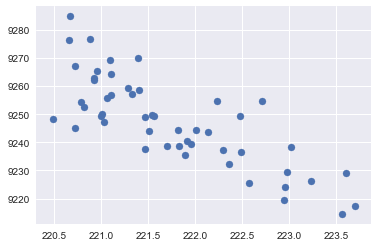

In [9]:
plt.scatter(ds['pwr'],ds['secs'])

(array([1., 0., 2., 2., 1., 1., 3., 1., 3., 4., 0., 0., 1., 1., 2., 2., 3.,
        0., 1., 0., 2., 1., 2., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 0.,
        1., 0., 0., 0., 3., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 1.]),
 array([220.48568726, 220.55007416, 220.61446106, 220.67884796,
        220.74323486, 220.80762177, 220.87200867, 220.93639557,
        221.00078247, 221.06516937, 221.12955627, 221.19394318,
        221.25833008, 221.32271698, 221.38710388, 221.45149078,
        221.51587769, 221.58026459, 221.64465149, 221.70903839,
        221.77342529, 221.83781219, 221.9021991 , 221.966586  ,
        222.0309729 , 222.0953598 , 222.1597467 , 222.22413361,
        222.28852051, 222.35290741, 222.41729431, 222.48168121,
        222.54606812, 222.61045502, 222.67484192, 222.73922882,
        222.80361572, 222.86800262, 222.93238953, 222.99677643,
        223.06116333, 223.12555023, 223.18993713, 223.25432404,
        223.31871094, 223.38309784, 223.44748474, 223.51187164,
      

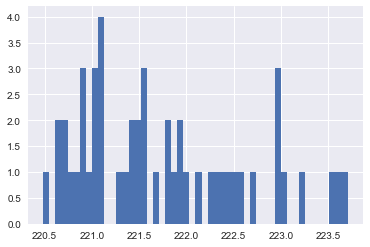

In [10]:
plt.hist(ds['pwr'],bins=50)

In [11]:
a = ds.groupby(['intento'])['secs'].agg('sum').sort_values(ascending=True)
a[:1].max()

9214.5859375

In [16]:
ganadores = pd.DataFrame(ds[ds['secs']<=a[:5].max()][['intento','list']])
ganadores

,intento,list
2,2,"[[0, 208.2247007302421, 40.29524, 187.41664, 1..."
17,17,"[[0, 210.2247007302421, 40.488586, 187.41664, ..."
23,23,"[[0, 215.2247007302421, 40.971947, 187.41664, ..."
29,29,"[[0, 203.2247007302421, 39.811886, 187.41664, ..."
44,44,"[[0, 207.2247007302421, 40.19857, 187.41664, 1..."


In [19]:
for i in range(len(ganadores)):
    if i == 0:
        df_ganador = pd.DataFrame(ganadores.values[i][1])
        df_ganador.columns =[["Tramos","Potencia","Velocidad","Distancia","Tiempo","Pendiente","Viento"]]
        df_ganador['Intento'] = ganadores.values[i][0]
    else:
        df_aux = pd.DataFrame(ganadores.values[i][1])
        df_aux.columns =[["Tramos","Potencia","Velocidad","Distancia","Tiempo","Pendiente","Viento"]]
        df_aux['Intento'] = ganadores.values[i][0]
        df_ganador = df_ganador.append([df_aux])
        del df_aux
df_ganador.to_excel('res_sim.xlsx')
df_ganador

,Tramos,Potencia,Velocidad,Distancia,Tiempo,Pendiente,Viento,Intento
0,0,208.224701,40.295238,187.416640,16.743912,-0.399565,14.918299,2
1,1,240.515508,39.832237,886.583360,80.128571,0.523132,14.577416,2
2,2,212.866869,40.014050,616.400000,55.456524,-0.240187,14.550887,2
3,3,234.451984,37.841526,1692.600000,161.023087,0.895103,14.552940,2
4,4,191.719745,42.504250,538.400000,45.601089,-1.235191,14.433466,2
5,5,229.496112,40.013275,19.266672,1.733425,0.176531,14.426397,2
6,6,206.121268,39.425480,40.449306,3.693487,-0.266013,14.457993,2
7,7,247.546603,39.667385,640.884022,58.163208,0.728433,14.370793,2
8,8,205.174433,39.616165,139.000000,12.631207,-0.367222,14.186360,2
9,9,269.772480,24.495344,1170.000000,171.951035,3.473797,14.525184,2


ganadores.index.values

In [ ]:
potencias_medias = df_ganador.groupby(['Tramos'])['Potencia'].agg('median')
#.sort_values(ascending=True)
#mean

In [ ]:
potencias_medias[0]

In [ ]:
#CON TENSORFLOW (SEGUNDA PASADA)
start_time = time.time()

pre_model = joblib.load('../Machine Learning/regr_porc_pwr.model') 

model_TF = load_model('../RNN/TF_Tramos_2.model')
model_Scalar = pickle.load(open("../RNN/Scaler.model", "rb"))



potencia_objetivo = 220
multiplicador_potencia = potencia_objetivo/pre_model.intercept_

resultados = []
fail = 0
exito = 0
num_pruebas = 50
fi = 0


while exito < num_pruebas:
    #print(exito)
    if (fi % 1000) == 0:
        print('Empezamos la prueba %d' %fi)
        print("--- %s seconds ---" % (time.time() - start_time))
    potencia_acum = 0
    tiempo_acum = 0
    i= 0
    lista_tramo_potencia = []
    while i < len(df):
        porc = df[i:i+1]["porc"].iloc[0]
        viento = df[i:i+1]["viento_aparente"].iloc[0]
        distancia = df[i:i+1]["dist"].iloc[0]
        
        #if porc < -2:
        #    potencia = pre_model.predict(porc)[0][0]*multiplicador_potencia+np.random.randint(-abs(porc), abs(porc))
        #elif porc > 2:
        #    #potencia = pre_model.predict(porc)[0][0]+50+np.random.randint(-abs(porc**2), abs(porc**2))
        #    potencia =potencia_objetivo+np.random.randint(0, abs(porc)+50)
        #else:
        #    potencia = potencia_objetivo+np.random.randint(-abs(porc)-10, abs(porc)+30)
        
        #potencia con una sigmoide
        #pot_min = 50
        #pot_max = 300
        #ff_1 = 0.5
        #ff_2 = 0.5
        
        #potencia = pot_min+(pot_max-pot_min)/(1+ff_1*np.e**(ff_2*porc*-1))+np.random.randint(-10, 10)
        
        potencia = potencias_medias[i]+np.random.randint(-10, 10)
        
        input_model = model_Scalar.transform([[potencia, porc, viento]])
        
        velocidad = model_TF.predict(input_model)[0]
        
        nuevo_tiempo = distancia/(velocidad/3.6)
        lista_tramo_potencia.append([i, potencia,velocidad[0],distancia,nuevo_tiempo[0],porc,viento])
        
        potencia_acum = potencia_acum + (potencia * nuevo_tiempo)
        tiempo_acum = tiempo_acum + nuevo_tiempo
        
        i += 1
    potencia_media = potencia_acum/tiempo_acum
    print("Intento %d con potencia media %d" %(fi, potencia_media))
    
    if (potencia_media > potencia_objetivo-20) and (potencia_media < potencia_objetivo+20):
        #print(potencia_media, tiempo_acum)
        resultados.append([fi,potencia_media[0], tiempo_acum[0], lista_tramo_potencia])
        exito +=1
    else:
        fail +=1
    
    fi +=1

print("---Total time: %s seconds ---" % (time.time() - start_time))

print('Casos descartados: %d' %fail)
print('Casos de favorables: %d' %(len(resultados)))